# Unbox the Cox: Why perfect predictors result in large p-values (0.9) ?

## Perfect predictors

Remember how we noted earlier that logistic regression has issue fitting perfectly separated data? In logistic regression, perfectly separated data results in infinite odds ratio ($\beta$). In Cox regression, hazard takes the place of odds so there may be a concern if we have to worry about anything here. The answer it "Yes, we do.".

Perfect predictors in Cox regression are predictors $x$ whose ranks exactly match ranks of event times (their Spearman correlation = 1). Here is a visual example of a modified sample data where we swapped event times for subjects C and D, to make $x$ a perfect predictor of event times:

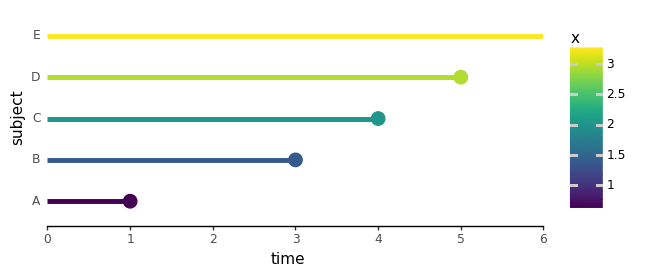

<ggplot: (327178535)>

In [24]:
import numpy as np
import pandas as pd
from cox.plots import (
    plot_subject_event_times,
    animate_subject_event_times_and_mark_at_risk,
    plot_cost_vs_beta,
)


perfect_df =  pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 4, 5, 6],
    'event': [1, 1, 1, 1, 0],
    # 'x': [-1.7, -0.4, 0.0, 0.9, 1.2],
	'x': [0.7, 1.4, 2.0, 2.9, 3.2],
})

plot_subject_event_times(perfect_df, color_map='x')

In [2]:
animate_subject_event_times_and_mark_at_risk(
    perfect_df, color_map='x'
).save('../images/cox_likelihood_fitting_perfect.gif')

![animated_likelihood_fitting](../images/cox_likelihood_fitting_perfect.gif)

In order to understand why these "perfect predictors" can be problematic for statistical inference, we will again plot our negative log-likelihood cost vs $\beta$:

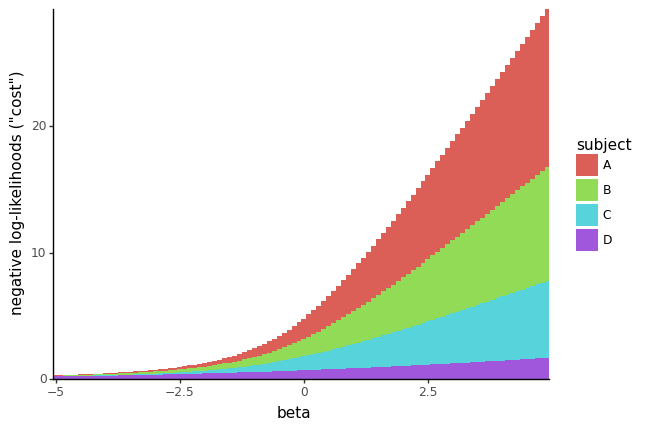

<ggplot: (327267413)>

In [23]:
def event_time_and_x_from_subject(df, subject):
    subject_with_event_df = df.query(f"subject == '{subject}' & event == 1")
    if subject_with_event_df.empty: # For censored subjects return infinite time
        return (np.inf, 0)
    return subject_with_event_df.iloc[0][['time', 'x']]

def subjects_at_risk_data(df, subject):
    time = event_time_and_x_from_subject(df, subject)[0]
    return df.query(f'time >= {time}')

def log_likelihood(df, subject, beta):
    x_subjects_at_risk = subjects_at_risk_data(df, subject)['x']
    x_subject = event_time_and_x_from_subject(df, subject)[1]
    at_risk_hazards = np.exp(beta * x_subjects_at_risk)
    return beta * x_subject - np.log(np.sum(at_risk_hazards))

def neg_log_likelihood_for_all_subjects(df, beta):
    subjects = df.query("event == 1")['subject'].tolist()
    neg_log_likelihoods = [-log_likelihood(df, subject, beta) for subject in subjects]
    return pd.DataFrame({
        'subject': subjects,
        'neg_log_likelihood': neg_log_likelihoods
    })

def neg_log_likelihood_all_subjects_sweep_betas(df, betas=np.arange(-5, 5, 0.1)):
    loglikelihoods_per_beta = []
    for beta in betas:
        beta_df = neg_log_likelihood_for_all_subjects(df, beta)
        beta_df.insert(0, 'beta', beta) # Add beta column
        loglikelihoods_per_beta.append(beta_df)
    return pd.concat(loglikelihoods_per_beta)

negloglik_sweep_betas_perfect_df = neg_log_likelihood_all_subjects_sweep_betas(
    perfect_df,
    betas=np.arange(-5, 5, 0.1)
)
plot_cost_vs_beta(negloglik_sweep_betas_perfect_df, width=0.1)

It is becoming more obvious that there is no minimum value of $\beta$, arbitrarily large negative values of $\beta$ result in arbitrarily good log-likelihood fits:

In [7]:
from lifelines import CoxPHFitter

perfect_cox_model = CoxPHFitter()
perfect_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_cox_model.print_summary()

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1586: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large. There may be complete separation in the dataset. This may result in incorrect inference of coefficients. See https://stats.stackexchange.com/q/11109/11867 for more.

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column x has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to con

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -0.00
         time fit was run = 2023-06-19 22:51:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x         -31.95       0.00     388.11          -792.62           728.73                 0.00                  inf

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -0.08 0.93       0.10
---
Concordance = 1.00
Partial AIC = 2.00
log-likelihood ratio test = 9.57 on 1 df
-log2(p) of ll-ratio test = 8.99

`-1.7, -0.4, 0.0, 0.9, 1.2`

If $\beta$ is large and positive, subjects A, B, have $e^{-1.7x}$, $e^{-0.4x}$

$$
\frac{e^{-1.7\beta}}{e^{-1.7\beta} + e^{-0.4\beta} + e^{0} + e^{0.9\beta} + e^{1.2\beta}}
$$

$$
\frac{e^{0.7\beta}}{e^{0.7\beta} + e^{1.4\beta} + e^{2.0\beta} + e^{2.9\beta} + e^{3.2\beta}}
$$

$$
\frac{e^{1.4\beta}}{e^{1.4\beta} + e^{2.0\beta} + e^{2.9\beta} + e^{3.2\beta}}
$$

$$
\frac{e^{2.0\beta}}{e^{2.0\beta} + e^{2.9\beta} + e^{3.2\beta}}
$$

What if D comes before C?

$$
L_A = \frac{e^{0.7\beta}}{e^{0.7\beta} + e^{1.4\beta} + e^{2.0\beta} + e^{2.9\beta} + e^{3.2\beta}}
$$

$$
L_B = \frac{e^{1.4\beta}}{e^{1.4\beta} + e^{2.0\beta} + e^{2.9\beta} + e^{3.2\beta}}
$$

$$
L_D = \frac{e^{2.9\beta}}{e^{2.0\beta} + e^{2.9\beta} + e^{3.2\beta}}
$$

$$
L_C = \frac{e^{2.0\beta}}{e^{2.0\beta} + e^{3.2\beta}}
$$

$$
\frac{}{}
$$

In [20]:
perfect_pen_cox_model = CoxPHFitter(penalizer=0.7, l1_ratio=0)
perfect_pen_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_pen_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.7
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -3.91
         time fit was run = 2023-06-19 22:57:48 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -0.52       0.59       0.39            -1.29             0.25                 0.27                 1.28

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.32 0.19       2.43
---
Concordance = 1.00
Partial AIC = 9.81
log-likelihood ratio test = 1.76 on 1 df
-log2(p) of ll-ratio test = 2.44